# Recommendation System Project Notebook Version

## read rating data and meta data 

3 files will be created (2 training and 1 testing)

* content-based file will have reviewerID, review text, asin, and rating. 80% from whole data
* collaborative filtering file will have reviewerID, asin, and rating. 80% from whole data(same data as above but no reviewText)
* testing file will have the rest 20% of data with reviewerID, asin, and rating.


In [1]:
import gzip
import csv
from random import randint

#read file from json.gz to csv and delete unused key 

#path file and number of data ex. 500k    
def parsecsvContent(path1, path2, path3, num):
    f = open(path1, 'wb') #content.csv file name
    a = open(path2, 'wb') #cf.csv filename
    b = open(path3, 'wb') #testing filename
    unusedKey = ['helpful', 'reviewerName', 'summary', 'unixReviewTime', 'reviewTime'] #for content based
    g = gzip.open("reviews_Movies_and_TV.json.gz", 'r') 
    count = 1
    for l in g:
        data = eval(l)
        #delete unusedkey
        for key in unusedKey:
            if key in data:
                del data[key]        
        #set header
        if count == 1:
            w = csv.DictWriter(f, data.keys()) #content
            w.writeheader()
            if('reviewText' in data):
                    del data['reviewText']
            u = csv.DictWriter(a, data.keys()) #cf
            u.writeheader()
            v = csv.DictWriter(b, data.keys()) #testing
            v.writeheader()

        count += 1
        if count == num:
            break
        # write data
        if count <= num:
            if(randint(0,9) < 2): #select 20%
                if('reviewText' in data):
                    del data['reviewText']
                v.writerow(data)
            else:
                w.writerow(data) # write to content.csv
                if('reviewText' in data):
                    del data['reviewText']
                u.writerow(data)
        
    f.close()
    a.close()
    b.close()
    return 0     
 
    
def parsecsvMeta(path):
    f = open(path, 'wb') #training set file name

    unusedMeta = ['title', 'imUrl', 'related', 'salesRank', 'brand', 'categories', 'description'] #for meta file

    g = gzip.open('meta_Movies_and_TV.json.gz', 'r') 
    count = 1
    for l in g:
        data = eval(l)
        #delete unusedkey
        for key in unusedMeta: 
            if key in data:
                del data[key]        
        #set header
        if count == 1:
            w = csv.DictWriter(f, data.keys())
            w.writeheader()

        count += 1

        w.writerow(data)
       
    f.close()
    return 0       


numData = 4000000 #total data used in project

parsecsvContent("ContentAll.csv", "CFAll.csv", "Testing20%.csv", numData)

parsecsvMeta("MetaData.csv")

print 'Finished creating files'

## run collaborative filtering

In [1]:
import pandas as pd
from pandas import *
from scipy import spatial
import numpy as np

#read data from csv
def readcsv(path):
    return pd.read_csv(path, iterator=True, chunksize=10000, skip_blank_lines=True)

#normalize cosine distance item-item

tp = readcsv("CFAll.csv")
df = concat(tp, ignore_index=True)

#delete item which has less number of ratings than 500
df = df.groupby("asin").filter(lambda x: len(x) > 500)

#create utility matrix
table = df.pivot_table(values='overall', index=['reviewerID'], columns=['asin'])
df = None
#normalize data
table = table.apply(lambda x: (x - np.mean(x)))


#fill emptyspace with 0
table = table.fillna(value=0)

#create table to hold result
result = pd.DataFrame(index=table.columns,columns=table.columns)


#for each item
for i in range(0,len(result.columns)):
    #compare with another item
    for j in range(0,len(result.columns)): 
        #find cosine similarity of item1 and item2
        result.ix[i,j] = 1-spatial.distance.cosine(table.ix[:,i],table.ix[:,j])
result.to_csv('cf_cosine.csv')
#table to hold the similarity of item
rank = pd.DataFrame(index=result.columns,columns=range(1,11))

#rank data based on cosine similarity(10)
for i in range(0,len(result.columns)):
    rank.ix[i,:10] = result.ix[0:,i].sort_values(ascending=False)[:10].index

#for i in range(0,len(result.columns)): (all)
#    rank.ix[i,:] = df1.ix[0:,i].order(ascending=False)[:].index

#write to file
rank.to_csv('result_cf_All.csv')

print 'Finished collaborative filtering'

Finished collaborative filtering


## run content-based

### get most frequence words

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', min_df = 0, stop_words = 'english')

def f(x):
     return Series(dict(Text = "{%s}" % ', '.join(str(ele) for ele in x['reviewText']), 
                        rating = x["overall"].mean()))

#read data from csv
def readcsv(path):
    return pd.read_csv(path, iterator=True, chunksize=10000, skip_blank_lines=True)

#normalize cosine distance item-item

tp = readcsv("ContentAll.csv")
df = concat(tp, ignore_index=True)

#delete item which has less number of ratings than 500
df = df.groupby("asin").filter(lambda x: len(x) > 500)
df = df.groupby("asin").apply(f)
#df = df.drop(df.columns[[0]], axis=1)

#print first asin review text
#print len(df.ix[1,0].split(','))



stopwords = ['movie', 'film', '"the', "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]


# Extract the vocabulary of keywords
vocab = dict()
sort_item = []
word_list = []
with open("MostFreq.txt", 'w') as outfile: #preprocess file content based
    for i in xrange(len(df)):
        avg_str = '\t'.join([str(df.index[i]), 'rating(avg)', str(df.ix[i,1])])
        avg_str = avg_str + '\n'
        outfile.write(avg_str)
        for text in df.ix[i,0].split(','):
            for term in text.split():
                term = term.lower()
                if len(term) > 2 and term not in stopwords:
                    if vocab.has_key(term):
                        vocab[term] = vocab[term] + 1
                    else:
                        vocab[term] = 1
        # Remove terms whose frequencies are less than a threshold (e.g., 20)
        vocab = {term: freq for term, freq in vocab.items() if freq > 100}
        sort_item = sorted(vocab, key=vocab.__getitem__, reverse=True)[:5]
        ##################
        #write down each word to file (new format)
        for item in sort_item:
            item_str = '\t'.join([str(df.index[i]), item, str(1)])
            item_str = item_str + '\n'
            outfile.write(item_str)
        ##################
        
        word_list.append(sort_item)
        vocab = dict()
        sort_item = []
print 'Finished getting most frequence word'

Finished getting most frequence word


In [3]:
from scipy import spatial
import pandas as pd


#read review text & avg rating
f = open('MostFreq.txt') #from content_based.py
data = []

for line in f:
    line = line.rstrip('\n').split('\t')
    if line[1] == 'rating(avg)':
        line[2] = float(line[2]) # convert str to float
    else:
        line[2] = float(line[2])# convert to int
    data.append(line)

df = pd.DataFrame(data)

#read price
df2 = pd.read_csv('MetaData.csv', index_col='asin')

#create matrix
data = None
M = df.pivot_table(values=2, index=0, columns=1).fillna(value=0)


#merge
merge_item = pd.merge(M, df2, left_index=True, right_index=True, how='inner').fillna(value=0)

#merge_item.to_csv('Example_mat.csv')

#create table to hold result
result = pd.DataFrame(index=merge_item.index,columns=merge_item.index)


#for each item
for i in range(0,len(merge_item.index)):
    #compare with another item
    for j in range(0,len(merge_item.index)): 
        #find cosine similarity of item1 and item2
        result.ix[i,j] = 1-spatial.distance.cosine(merge_item.ix[i,:],merge_item.ix[j,:])
        
result.to_csv('content_cosine.csv')
#table to hold the similarity of item
rank = pd.DataFrame(index=result.columns,columns=range(1,11))

#rank data based on cosine similarity(10)
for i in range(0,len(result.columns)):
    rank.ix[i,:10] = result.ix[0:,i].sort_values(ascending=False)[:10].index
    
#for i in range(0,len(result.columns)): 
#    rank.ix[i,:] = df1.ix[0:,i].order(ascending=False)[:].index

#write to file
rank.to_csv('result_content_All.csv')
print 'Finished content based'

Finished content based


## Testing

Create user to item table

In [4]:
import pandas as pd
from pandas import *

def readcsv(path):
    return pd.read_csv(path, iterator=True, chunksize=10000, skip_blank_lines=True)

def f(x):
    return Series(dict(Product_ID="{%s}" % ', '.join(str(ele) for ele in x['asin'])))

tp = readcsv("Testing20%.csv") #get file from read_csv.py
df = concat(tp, ignore_index=True)

df = df.groupby("reviewerID").filter(lambda x: len(x) > 1)
df = df.groupby("reviewerID").apply(f)

print len(df)

df.to_csv("UserToItemTableTest.csv")

90846


using precision recall for testing

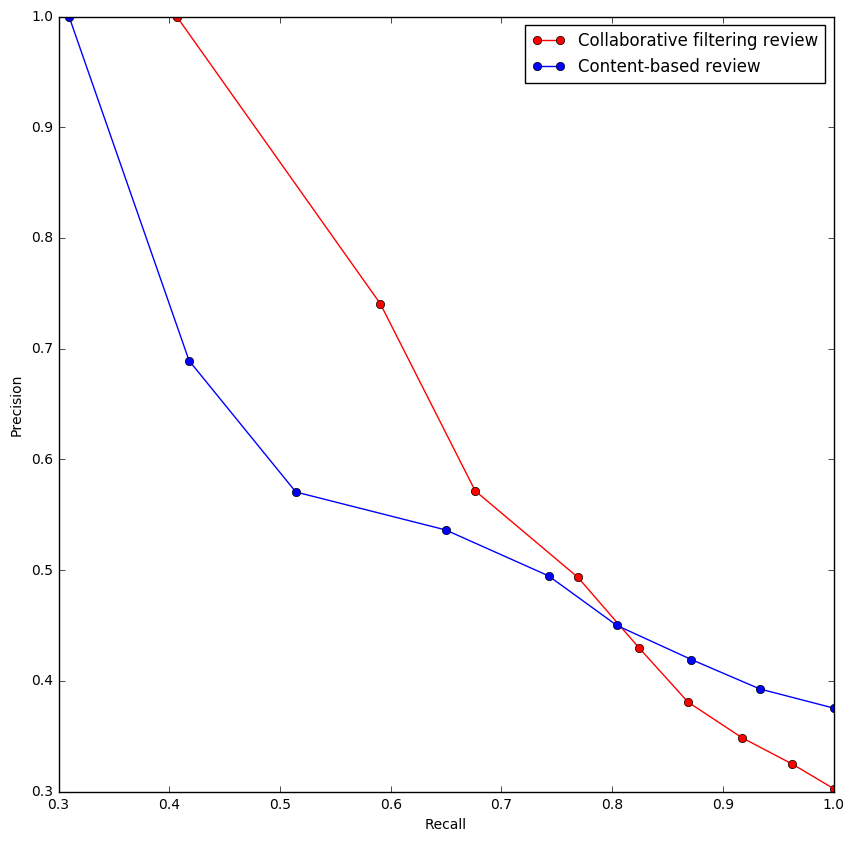

In [2]:
import pandas as pd
from pandas import *
import random
import math
import matplotlib.pyplot as plt

f = open('UserToItemTableTest.csv') #from UserToItemTable.py
all_item = []
hide_item = []
y_true = []
#print df['Product_ID']
for item in f:
    item = item.replace('{', '').replace('}', '').replace('"', '').replace(' ', '')
    item = item.rstrip().split(',')
    all_item.append(item)
    y_true.append(item[1:])
    random_item = random.sample(item[1:], int(round((len(item)*0.6) - 0.5))) #hide 40% of data
#    print random_item
#    random_item.insert(0, item[0]) #insert reviewerid infront of list of itemid
    hide_item.append(random_item)
    
del y_true[0]


Precision_content = []
Recall_content = []
Precision_collab = []
Recall_collab = []

for it in range(2):
    for k in xrange(1,10):
        if (it == 0):
            sim = open('result_content_All.csv') # content based
        if (it == 1):
            sim = open('result_CF_All.csv') # collaborative
        
        sim_item = []
        sim_key = []
    #    k = 9 #number of k
        
        #read similar item from file and append in list
        sim_key = []
        sim_item = []
        
        for item in sim:
            item = item.rstrip().split(',')
            sim_key.append(item[0])
            sim_item.append(item[1:k+2])
        sim.close()
        
        #set up y pred 
        y_pred = []
        for i in xrange(1, len(hide_item)):
            recommend_item = []
            for j in hide_item[i]:
                if j in sim_key:
                    recommend_item = recommend_item + sim_item[sim_key.index(j)][1:]
            if (len(recommend_item) != 0):
                recommend_item = list(set(recommend_item) - set(hide_item[i]))
            y_pred.append(recommend_item)
        
        
        total_recall = 0.0
        total_precision = 0.0
        max_recall = 0.0
        max_precision = 0.0
        ##calculate precision & recall
        for i in xrange(len(y_true)):
            if len(y_pred[i]) == 0:
                total_precision += 0.0
                total_recall += 0.0
            else:
                tp = len(list(set(y_true[i]) & set(y_pred[i])))
                precision = float(tp)/float(len(y_pred[i]))
                recall = float(tp)/float(len(y_true[i]))
                if (precision > max_precision):
                    max_precision = precision
                if (recall > max_recall):
                    max_recall = recall
                total_precision += precision
                total_recall += recall
                
                
        total_precision = (total_precision/len(y_true))
        total_recall = (total_recall/len(y_true))
        if (it == 0):
            Precision_content.append(total_precision)
            Recall_content.append(total_recall)
        if (it == 1):
            Precision_collab.append(total_precision)
            Recall_collab.append(total_recall)


#normalize data to be in range [0,1]
norm_precision_collab = [float(i)/max(Precision_collab) for i in Precision_collab]

norm_recall_collab = [float(i)/max(Recall_collab) for i in Recall_collab]

norm_precision_content = [float(i)/max(Precision_content) for i in Precision_content]
 
norm_recall_content = [float(i)/max(Recall_content) for i in Recall_content]

plt.figure(figsize=(10,10))
plt.plot(norm_recall_collab, norm_precision_collab, 'r-o', label = 'Collaborative filtering review')
plt.plot(norm_recall_content,norm_precision_content, 'b-o', label = 'Content-based review')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.axis()
plt.legend(loc='upper right')

plt.show()

We calculate the precision and recall based on the number of items that fall into each cell. The maximum numbers of recommended item is 10 in our project.
for the figure, if we increase the numbers of recommended item the precision will decrease while the recall will increase. The collaborative filtering tends to have a better performance than the content based.